In [33]:
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
import os
from pathlib import Path
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)

sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP")
sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos")

directory = Path('/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos')
resource_dir = directory / "resource_files"
params_dir = directory / "parameter_files"
results_dir = directory / "results"

import pandas as pd
import os
import re
import sys
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import *

from cycler import cycler

import json_lines # https://github.com/TeamHG-Memex/json-lines

from IPython.display import display, HTML


from matplotlib.animation import (
    PillowWriter,
    )
from matplotlib.lines import Line2D
from pylab import rcParams

from hybrid.sites import SiteInfo

from tools.optimization import setup_run, NullDataRecorder

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# plt.rcParams['figure.figsize'] = [10, 8]

plt.style.use('seaborn-whitegrid')
plt.ion()
# plt.rcParams['figure.figsize'] = [10, 8]
# params = {'legend.fontsize': 20,
#           'legend.handlelength': 2}

rcParams['figure.figsize'] = 3, 7
rcParams['lines.linewidth'] = 4

# plt.locator_params(nbins=4)

workbookDir: /Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results


In [18]:

font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 19}
plt.rc('font', **font)

In [38]:
from pathlib import Path
from optimize_npv import HybridLayoutProblem, WindBoundaryGridParameters, PVGridParameters, module_power, simulation_options, dispatch_options
from hybrid.sites import flatirons_site

solution_vars = ["border_spacing", "border_offset", "grid_angle", "grid_aspect_power", "row_phase_offset", "num_turbines_ratio_max", "solar_x_position", "solar_y_position", "solar_aspect_power", "solar_gcr", "solar_s_buffer", "solar_x_buffer", "solar_ratio_of_max_mw", "battery_ratio_of_max_mw"]


def create_hybrid_plant():
    solar_file = resource_dir / "32.43861838431444__-99.73363995829895_32.438818_-99.734703_psm3_60_2013.csv"
    wind_file = resource_dir / "lat32.43_lon-99.73__2013_120m.srw"
    prices_file = resource_dir / "pricing-data-2015-IronMtn-002_factors.csv"
    site = SiteInfo(flatirons_site,
                    solar_resource_file=solar_file,
                    wind_resource_file=wind_file,
                    grid_resource_file=prices_file)
    
    with open(params_dir / "pv_parameters.json", 'r') as f:
        pv_info = json.load(f)["SystemDesign"]
    with open(params_dir / "wind_parameters.json", 'r') as f:
        wind_info = json.load(f)
    turb_rating_kw = max(wind_info['Turbine']['wind_turbine_powercurve_powerout'])
    with open(params_dir / "financial_parameters.json", 'r') as f:
        fin_info = json.load(f)
    cost_info = fin_info['capex']
        
    problem = HybridLayoutProblem(site_info=site, cost_config=dict(), sim_config=simulation_options, dispatch_config=dispatch_options, 
                                  turb_size_kw=6000, pv_config=pv_info, wind_config=wind_info,
                                  fin_config=fin_info)
    return problem

problem = create_hybrid_plant()

bounds = problem.site.polygon.bounds
site_sw_bound = np.array([bounds[0], bounds[1]])
site_ne_bound = np.array([bounds[2], bounds[3]])
site_center = .5 * (site_sw_bound + site_ne_bound)
max_delta = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
reach = (max_delta / 2) * 1.3
min_plot_bound = site_center - reach
max_plot_bound = site_center + reach

In [37]:
# clean up the data so num evaluations are the same across

def fill_incomplete(ordering):
    for i, run_group in enumerate(ordering):
        run_data = aggregated_data_sets[run_group]
        evals = run_data["num_evaluations"]
#         print(aggregated_data_sets[run_group]["num_evaluations"])

        max_evals = len(evals)
    #     print(max_evals, run_data)
        for k in run_data['num_evaluations'].keys():
            for n, row in enumerate(run_data['num_evaluations'][k]):
                if row != row:
                    aggregated_data_sets[run_group]['num_evaluations'][k].iloc[n]= run_data['num_evaluations'][k][n - 1] + 100
            for n, row in enumerate(run_data['best_evaluation'][k]):
                if row != row:
                    aggregated_data_sets[run_group]['best_evaluation'][k].iloc[n] = run_data['best_evaluation'][k][n - 1]
#         print(aggregated_data_sets[run_group]["best_evaluation"])

# fill_incomplete(['financial_no_grid_charge_results'])

In [77]:
# colors = [
#     (0.0,0.0,1.0),
#     (0.0,1.0,0.0),
#     (1.0,0.0,0.0),
#     (0.0,0.7,0.7),
#     (0.7,0.7,0.0),
#     (0.0,0.0,0.0),
#     (0.5,0.5,0.5),
# ]


wind_color = (153 / 255, 142 / 255, 195 / 255)
solar_color = (241 / 255, 163 / 255, 64 / 255)
batt_color = (65 / 255, 121 / 255, 251 / 255)
flicker_color = (27/255.0,158/255.0,119/255.0)


colors = [
#     (67/255.0,185/255.0,269/255.0),
    (223 / 255, 142 / 255, 195 / 255),
    (86 / 255, 163 / 255, 64 / 255),
    (165 / 255, 121 / 255, 251 / 255),
    (127/255.0, 58/255.0,119/255.0)
]

solar_max_mw = 300
turbines_max = 62
battery_max_mw = 300
def plot_site(candidate, min_plot_bound, max_plot_bound, site_fig_size, title):

    site_border_color = (0, 0, 0)
    fig, ax = plt.subplots(1, figsize=site_fig_size)
    ax.axis('scaled')
    ax.set(xlim=(min_plot_bound[0], max_plot_bound[0]), ylim=(min_plot_bound[1], max_plot_bound[1]))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.margins(y=0, x=0)
    
    problem = create_hybrid_plant()
    simulation = problem._set_simulation_to_candidate(candidate)
    simulation.site.plot(fig, ax, site_border_color)
    simulation.layout.plot(fig, ax,
                           wind_color='b',
                           pv_color=solar_color,
                           site_border_color=site_border_color)
    
    plt.tight_layout()
    wind_mw = simulation.wind.num_turbines * 6
    solar_mw = simulation.pv.system_capacity_kw * 1e-3
    batt_mw = simulation.battery.system_capacity_kw * 1e-3
    plt.title(f"{round(wind_mw)} MW Wind, {round(solar_mw)} MW Solar, {round(batt_mw)} MW Battery")
    plt.suptitle(title)
    plt.margins(0,0)
    plt.show()

    return fig
    
def plot_sites(site_data, runs, group_name, site_fig_size):
    ds = None
    for j, (run_name, data_set) in enumerate(runs.items()):
    #     print(run_name)
        ds = data_set
        json_candidate = data_set.at[len(data_set.index)-1, 'best_solution']
        evaluation = data_set.at[len(data_set.index)-1, 'best_evaluation']
        title = run_name.split('.jsonl')[0] + f"x Best NPV ${round(evaluation * 1e-6, 2)}M"
        fig = plot_site(json_candidate, min_plot_bound, max_plot_bound, site_fig_size, title)
        score = data_set.at[len(data_set.index)-1, 'best_score']
        baseline_value = data_set.at[data_set.index[0], 'best_score']

        print(json_candidate, score, evaluation, run_name)

#         plt.label(str(evaluation / 1e3) + 'GWh AEP')
#         plt.savefig(group_name + '_' + str(j) + '_layout.svg')
        fig.savefig(results_dir / "fig_layout.png")
#         fig2.savefig(group_name + '_' + str(j) + '_stats.svg')
    
    return json_candidate, evaluation, score, baseline_value

In [67]:

def smooth_aggregated_column(aggregated_column, window_size):
    print('ws ', window_size)
    return aggregated_column.rolling(window=window_size,axis=0).mean()

def plot_quantile(ax, x, aggregated_column, color=(0,0,.8), alpha=.25, value=.5):
    q1 = aggregated_column.quantile(.5+value/2, 1).values.tolist()
    q2 = aggregated_column.quantile(.5-value/2, 1).values.tolist()
    ax.fill_between(x, q1, q2, color=(*color, alpha))

def plot_quantiles(ax, x, aggregated_column, color=(0,0,.8), alpha=.5, value=.5):
#     plot_quantile(ax, x, aggregated_column, color, alpha, value)
    plot_quantile(ax, x, aggregated_column, color, alpha * .5, value * 2)
    ax.plot(x, aggregated_column.quantile(.5, 1), color=color)

def plot_smooth_quantiles(x, aggregated_column, window_size=5, **kwargs):
    plot_quantiles(x, smooth_aggregated_column(aggregated_column, window_size), **kwargs)
    
def normalize_sequence(seq):
    hi = max(seq)
    lo = min(seq)
    scale = max(1e-6, hi - lo)
    return [(x-lo) / scale for x in seq]


def setup_minor_ticks(ax):
    ax.minorticks_on()
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def plot_perf(aggregated_data_sets, baseline_value, ordering, figsize=(10,8)):
    def aep_to_pct(x):
        return x * 1e-6

    def gwh_to_pct(x):
        return x

    def pct_to_gwh(y):
        return y

    fig, ax = plt.subplots(1, figsize=figsize)
    
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    setup_minor_ticks(ax)

    ax.minorticks_on()

    plt.ylabel('NPV ($mil)')
    plt.xlabel('# of candidates evaluated')
    
    labels = []
        
    for i, run_group in enumerate(ordering):
        run_data = aggregated_data_sets[run_group]
        scores = run_data['best_evaluation']
        pct = aep_to_pct(scores)
        plot_quantiles(ax, run_data['num_evaluations'].median(1) + 200, pct, color=colors[i%len(colors)])
        labels.append(run_group)
        
#         print(scores.mean(1).values[-1])
        print('{} mean {} stdev {} median {}\n'.format(run_group, pct.mean(1).values[-1], pct.std(1).values[-1], pct.median(1).values[-1]))
    
    return fig, ax, None


In [79]:
# print(os.listdir('.'))
# print(os.path.dirname(os.path.realpath('.')))

def load_results(path, run_group, index='iteration'):
#     run_name_extractor = re.compile(r'^(.*)_(\d\d\d\d\-\d\d\-\d\dT\d\d\.\d\d\.\d\d\.\d+)$')
    run_name_extractor = re.compile(r'^(.*)_([^_]+)$')
    
    dirs = [f for f in os.listdir(path)]
    print(dirs)
#     source_files = [os.path.join([p for p in os.listdir(d) if p.endswith('log.jsonl')][0],d,path) for d in dirs]
#     print(source_files)
#     pprint(os.listdir(path))

#     aggregated_columns = {}
    data_sets = {}
    for d in dirs:
#         match = run_name_extractor.match(d)
#         if not match:
#             continue
        
        dir_path = os.path.join(path, d)
        print(dir_path)
#         print(match, run_group, run_name)
#         files = [p for p in os.listdir(dir_path) if p.endswith('log.jsonl')]
#         if len(files) == 0:
#             print('skipping', d)
#             continue # skip this directory
        if '.jsonl' not in dir_path:
            continue
            
        if 'copy' in dir_path:
            continue
    
        f = os.path.join(dir_path)
        
        columns = []
        data = None
        with open(f, 'rb') as file:
            print(f)
            columns = next(json_lines.reader(file))

            data_set = pd.DataFrame(json_lines.reader(file), columns = columns)

        data_set.set_index(index, inplace=True)
        
        if run_group not in data_sets:
            data_sets[run_group] = {}
        run_data_sets = data_sets[run_group]
        run_data_sets[run_group] = data_set
        
    return data_sets

def make_aggregated_data_set(data_sets):
    aggregated_data_sets = {}
    for run_group, runs in data_sets.items():
        group_data = {}
        for run_name, data_set in runs.items():
            for column in data_set.columns:
                if column not in group_data:
                    group_data[column] = pd.DataFrame()
                group_data[column][run_name] = data_set[column]
        aggregated_data_sets[run_group] = group_data
    return aggregated_data_sets


def extract_solution_vars(data_sets, solution_vars, solution_name = 'best_solution'):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            if solution_vars is None:
                solution_vars = sorted(solutions.iloc[0].keys())
            for n, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[n] for row in solutions]
    return solution_vars

def unpack_solution_vars(data_sets, solution_vars, solution_name):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            for i, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[i] for row in solutions]
            
def load_and_preprocess(directory, run_name):
    data_sets = load_results(directory, run_name)
    print('data_sets', data_sets)
    extract_solution_vars(data_sets, solution_vars)
    unpack_solution_vars(data_sets, solution_vars, 'mean')
    unpack_solution_vars(data_sets, solution_vars, 'variance')
    aggregated_data_sets = make_aggregated_data_set(data_sets)

    for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
        print(run_group)
    return data_sets, aggregated_data_sets, solution_vars


In [80]:
data_sets = load_results(results_dir/"EP4.25_GC_0_NPV", "EP4.25_GC_0_NPV")

['results.log.jsonl', 'README.json']
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/README.json


In [97]:
print(data_sets['EP4.25_GC_0_NPV']['EP4.25_GC_0_NPV']['best_solution'].values[-1])
print(data_sets['EP4.25_GC_0_NPV']['EP4.25_GC_0_NPV']['best_score'].values[-1])

[8.273861950500912, 0.0, 2.215438251144771, -0.5990308745233592, 0.3370498165090887, 0.0, 0.5692060027320252, 0.336565603590347, 0.22708080692015087, 0.23625796087304649, 2.900603473909988, 8.106257286639625, 0.4100764661988576, 0.0054485233298723155]
13018087.492825286


In [96]:
data_sets['EP4.25_GC_0_NPV']['EP4.25_GC_0_NPV']

,generation,mean,variance,covariance,_sigma,_p_c,_p_sigma,num_evaluations,best_score,best_evaluation,best_solution,best_solution.border_spacing,best_solution.border_offset,best_solution.grid_angle,best_solution.grid_aspect_power,best_solution.row_phase_offset,best_solution.num_turbines_ratio_max,best_solution.solar_x_position,best_solution.solar_y_position,best_solution.solar_aspect_power,best_solution.solar_gcr,best_solution.solar_s_buffer,best_solution.solar_x_buffer,best_solution.solar_ratio_of_max_mw,best_solution.battery_ratio_of_max_mw,mean.border_spacing,mean.border_offset,mean.grid_angle,mean.grid_aspect_power,mean.row_phase_offset,mean.num_turbines_ratio_max,mean.solar_x_position,mean.solar_y_position,mean.solar_aspect_power,mean.solar_gcr,mean.solar_s_buffer,mean.solar_x_buffer,mean.solar_ratio_of_max_mw,mean.battery_ratio_of_max_mw,variance.border_spacing,variance.border_offset,variance.grid_angle,variance.grid_aspect_power,variance.row_phase_offset,variance.num_turbines_ratio_max,variance.solar_x_position,variance.solar_y_position,variance.solar_aspect_power,variance.solar_gcr,variance.solar_s_buffer,variance.solar_x_buffer,variance.solar_ratio_of_max_mw,variance.battery_ratio_of_max_mw
iteration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"[[-62115947.90928237, -62115923.819631875, [2....","[5.127797965738343, 0.36262901219442634, 1.502...","[26.229874108570524, 3.5948650326659815, 9.400...","[[26.229874108570524, -0.03985030361809009, -0...",0.577443,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.1936012632190464], [-0.5202586092657177], ...",100,-6.211595e+07,-6.211592e+07,"[2.530084845007706, 0.0, 2.73879592156938, -1....",2.530085,0.0,2.738796,-1.224888,0.427902,0.165854,0.022512,0.955226,-2.017540,0.522796,3.694898,3.956598,0.470634,0.327343,5.127798,0.362629,1.502043,-0.467854,0.491466,0.310903,0.432653,0.575657,0.118801,0.429537,3.772524,3.764649,0.497560,0.400051,26.229874,3.594865,9.400860,8.527655,0.240597,0.263368,0.243105,0.256535,9.021218,0.231027,15.029004,14.715686,0.038132,0.041856
2,"[[-17684957.540725917, -17684907.412387222, [7...","[5.327465636960992, 0.44783419746547604, 1.531...","[24.80107170737558, 3.221627845718375, 8.82624...","[[24.80107170737558, -0.017701790328000396, -0...",0.878215,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.3834437891248703], [0.09995824768209413], ...",200,-1.768496e+07,-1.768491e+07,"[7.139334423880799, 0.0, 0.38949586993518714, ...",7.139334,0.0,0.389496,-4.000000,0.737105,0.261450,0.540315,0.799037,3.620508,0.271650,3.574317,4.315435,0.515279,0.131309,5.327466,0.447834,1.531419,-1.241116,0.536441,0.128594,0.506727,0.585925,0.753841,0.425119,3.199472,4.468696,0.505488,0.235325,24.801072,3.221628,8.826244,8.436860,0.239259,0.250886,0.237058,0.261820,9.541418,0.215276,14.633919,13.948648,0.037638,0.047992
3,"[[12982780.743944628, 12982807.126546502, [9.1...","[5.493255639204542, 0.583092068874653, 1.97469...","[23.92831365383646, 2.8629608015774193, 7.9608...","[[23.92831365383646, -0.027746563864251172, -0...",1.276241,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.31209011860938607], [0.3751248032871617], ...",300,1.298278e+07,1.298281e+07,"[9.1038853654285, 1.0, 3.141592653589793, -4.0...",9.103885,1.0,3.141593,-4.000000,0.724254,0.000000,0.191194,0.947150,-1.211042,0.327646,3.506811,0.986229,0.591930,0.005732,5.493256,0.583092,1.974693,-1.654711,0.512436,0.162738,0.527606,0.538667,0.818526,0.357171,3.942792,3.965745,0.520683,0.020790,23.928314,2.862961,7.960862,8.512560,0.226629,0.233995,0.226500,0.252942,9.104614,0.198787,14.280901,13.764648,0.036008,0.049402
4,"[[5060887.633411424, 5061014.269958451, [5.585...","[5.958096705607324, 0.34395167689784517, 1.951...","[21.790299344160513, 2.5203906992526854, 7.087...","[[21.790299344160513, 0.009270816297571545, -0...",1.344810,"[[1.0386921200921715], [-0.5343616532512485], ...","[[0.39613049023998337], [-0.27989175452984927]...",400,1.298278e+07,1.298281e+07,"[9.1038853

In [83]:
runs = ("EP4.25_GC_0_NPV", "EP4.25_GC_1_NPV", "EP4.5_GC_0_NPV", "EP4.5_GC_1_NPV", "EP4.75_GC_0_NPV", "EP4.75_GC_1_NPV")
# runs = ["25_GC_0_NPV"]
aggregated_data_sets = dict()
data_sets = dict()
for r in runs:
    data_set, aggregated_data_set, _ = load_and_preprocess(results_dir / r, r)
    aggregated_data_sets.update(aggregated_data_set)
    data_sets.update(data_set)
aggregated_data_sets.keys()


['results.log.jsonl', 'README.json']
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV/README.json
data_sets {'EP4.25_GC_0_NPV': {'EP4.25_GC_0_NPV':                                                   generation  \
iteration                                                      
1          [[-62115947.90928237, -62115923.819631875, [2....   
2          [[-17684957.540725917, -17684907.412387222, [7...   
3          [[12982780.743944628, 12982807.126546502, [9.1...   
4          [[5060887.633411424, 5061014.269958451, [5.585...   
5          [[0, 0, [1.2017579089602446, 0.0, 3.1415926535...   
6          [[3475646.2155393157, 3475830.3145881593, [0.0...   
7          [[5154701.138333629, 5154886.205702573, [0.0, ...   
8          [[7468636.7131

data_sets {'EP4.25_GC_1_NPV': {'EP4.25_GC_1_NPV':                                                   generation  \
iteration                                                      
1          [[-17094637.03420593, -17094584.82177061, [2.9...   
2          [[0, 0, [9.972611049137484, 1.0, 3.14159265358...   
3          [[3862527.998624356, 3862560.319800377, [0.0, ...   
4          [[4802894.445579851, 4803073.366231203, [1.132...   
5          [[6356913.842175605, 6357082.488304764, [8.976...   
6          [[7069052.056320189, 7069119.133977428, [8.588...   
7          [[8130081.449729736, 8130087.464506105, [7.859...   
8          [[10387948.93137201, 10388042.230805099, [4.02...   
9          [[9779420.277754672, 9779509.043450773, [6.374...   
10         [[12339565.523842806, 12339650.088042736, [14....   
11         [[9660465.122134082, 9660521.309809357, [10.57...   
12         [[9054267.891278414, 9054380.235337645, [19.60...   
13         [[11519396.83514812, 11519476.201496989, [4

data_sets {'EP4.5_GC_0_NPV': {'EP4.5_GC_0_NPV':                                                   generation  \
iteration                                                      
1          [[-41575805.7390924, -41575749.99878079, [4.50...   
2          [[0, 0, [2.000405974918978, 0.4636459504505434...   
3          [[12374166.212649465, 12374246.663813323, [2.3...   
4          [[14327242.850603271, 14327312.15974325, [13.6...   
5          [[12823154.325243667, 12823177.676922902, [13....   
6          [[20147753.6708367, 20147810.466431618, [15.42...   
7          [[18295957.539609246, 18296037.851155102, [19....   
8          [[20960577.544595353, 20960671.359036833, [7.7...   
9          [[17807892.022913452, 17807956.667298168, [15....   
10         [[17032794.83491988, 17032834.215646565, [8.50...   
11         [[19685067.944196697, 19685161.765177906, [0.0...   
12         [[19938040.367824074, 19938093.633317232, [2.3...   
13         [[20519397.806797963, 20519457.742340595, [3.

data_sets {'EP4.5_GC_1_NPV': {'EP4.5_GC_1_NPV':                                                   generation  \
iteration                                                      
1          [[-37621914.26328994, -37621878.55647543, [2.9...   
2          [[6902293.836036722, 6902310.549009889, [7.345...   
3          [[19938633.470873296, 19938743.952670842, [4.9...   
4          [[9780966.746044748, 9781044.577692479, [0.0, ...   
5          [[11754338.619023766, 11754539.900196001, [6.1...   
6          [[12248919.044316227, 12248990.78837338, [5.54...   
7          [[12424654.021473702, 12424713.873842388, [16....   
8          [[21309401.178580265, 21309427.7600013, [1.655...   
9          [[17106125.902537156, 17106220.567925096, [8.9...   
10         [[17404203.938228887, 17404255.471021175, [4.9...   
11         [[21553854.957118988, 21553900.52002701, [4.31...   
12         [[20654145.775052145, 20654175.713052094, [8.9...   
13         [[20449752.491105713, 20449818.48868811, [6.1

data_sets {'EP4.75_GC_0_NPV': {'EP4.75_GC_0_NPV':                                                   generation  \
iteration                                                      
1          [[-31927341.976143386, -31927310.859677583, [6...   
2          [[14066955.064582117, 14067010.813245445, [5.3...   
3          [[23084246.812661335, 23084267.877276123, [8.8...   
4          [[24043268.21484269, 24043401.242524385, [8.41...   
5          [[18581569.096761048, 18581596.721145123, [2.9...   
6          [[22744161.812790874, 22744233.88460976, [3.95...   
7          [[29297643.68238752, 29297654.818518102, [5.64...   
8          [[30009158.9505711, 30009183.869649917, [6.435...   
9          [[29083253.510211267, 29083272.23139313, [6.12...   
10         [[29894484.193881232, 29894521.134553343, [5.6...   
11         [[28384096.580980685, 28384133.14423147, [5.28...   
12         [[29507691.926142007, 29507697.181195766, [6.4...   
13         [[29083517.555794917, 29083523.955918282, [

data_sets {'EP4.75_GC_1_NPV': {'EP4.75_GC_1_NPV':                                                   generation  \
iteration                                                      
1          [[-20542478.678487595, -20542472.89511037, [2....   
2          [[4885113.159381887, 4885145.493126661, [5.687...   
3          [[25542694.77175235, 25542710.09752202, [8.796...   
4          [[23303761.79984852, 23303778.000629365, [12.8...   
5          [[15280399.572203925, 15280477.430713445, [11....   
6          [[20585958.59786655, 20585971.804062575, [1.44...   
7          [[24892795.184509885, 24892921.218700945, [0.0...   
8          [[28097609.960719824, 28097634.757056117, [0.0...   
9          [[24304924.363690075, 24304995.43403676, [11.1...   
10         [[26786520.139334373, 26786535.343238324, [9.2...   
11         [[24111753.072626498, 24111764.934173137, [8.5...   
12         [[27839899.189059038, 27839916.909317493, [9.5...   
13         [[27694023.242178198, 27694063.651851743, [

dict_keys(['EP4.25_GC_0_NPV', 'EP4.25_GC_1_NPV', 'EP4.5_GC_0_NPV', 'EP4.5_GC_1_NPV', 'EP4.75_GC_0_NPV', 'EP4.75_GC_1_NPV'])

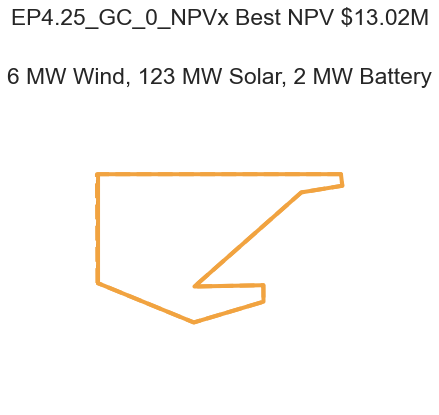

[8.273861950500912, 0.0, 2.215438251144771, -0.5990308745233592, 0.3370498165090887, 0.0, 0.5692060027320252, 0.336565603590347, 0.22708080692015087, 0.23625796087304649, 2.900603473909988, 8.106257286639625, 0.4100764661988576, 0.0054485233298723155] 13018087.492825286 13018162.345514864 EP4.25_GC_0_NPV
-62115947.90928237
EP4.25_GC_0_NPV mean 13.018162345514863 stdev nan median 13.018162345514863



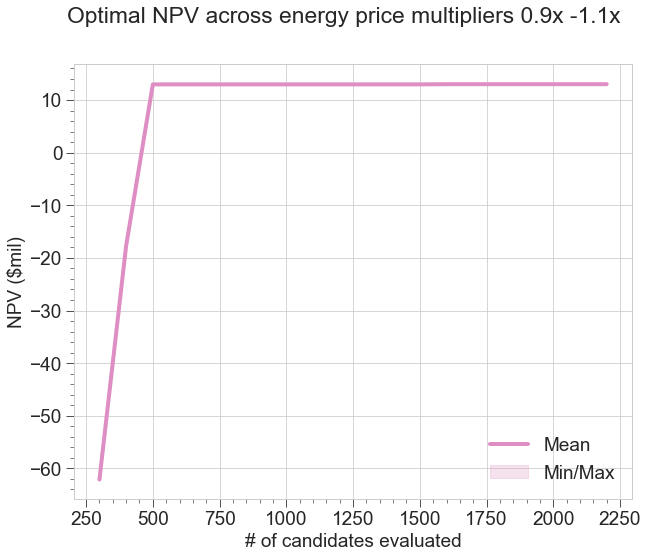

-62115947.90928237


In [84]:
current_run = run_group = 'EP4.25_GC_0_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(flatirons_site, runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 172267.86000000002 kw into existing PV layout parameters of PVGridParameters(x_position=0.9177716370186693, y_position=0.7610161934872114, aspect_power=1.4582909572295777, gcr=0.29315578197692865, s_buffer=0.0, x_buffer=7.9545465542457725)


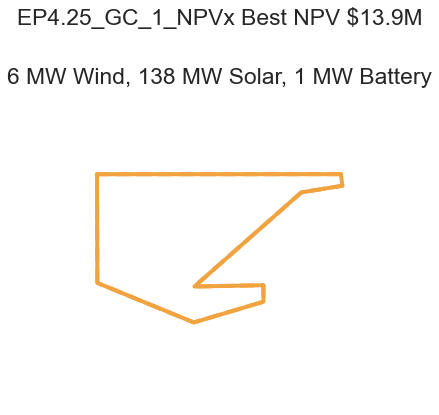

[7.067260800469039, 0.5259878796555963, 0.9403623911018928, 2.2161166421564453, 0.36382034032963895, 0.0, 0.9177716370186693, 0.7610161934872114, 1.4582909572295777, 0.29315578197692865, 0.0, 7.9545465542457725, 0.5742265322310575, 0.0025627942379846218] 13898307.562713783 13898375.303332359 EP4.25_GC_1_NPV
-17094637.03420593
EP4.25_GC_1_NPV mean 13.898375303332358 stdev nan median 13.898375303332358



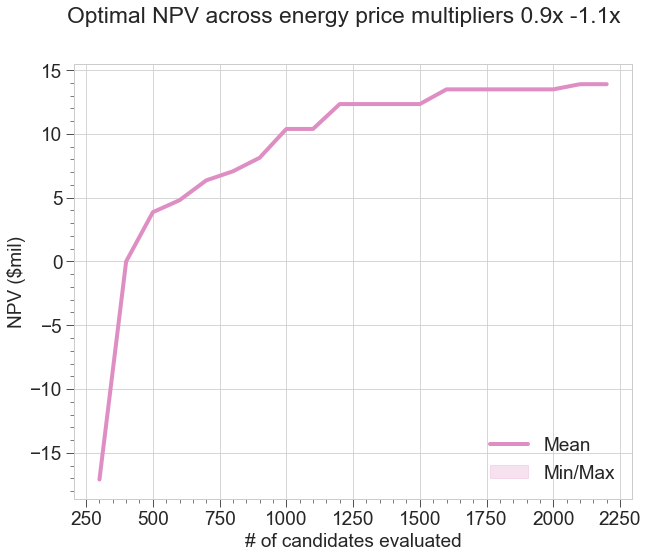

-17094637.03420593


In [85]:
current_run = run_group = 'EP4.25_GC_1_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(flatirons_site, runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 239848.953 kw into existing PV layout parameters of PVGridParameters(x_position=0.3512411966085236, y_position=0.4262158621687766, aspect_power=1.7731139839826067, gcr=0.329233414950439, s_buffer=5.001064443809419, x_buffer=3.0474801348105607)


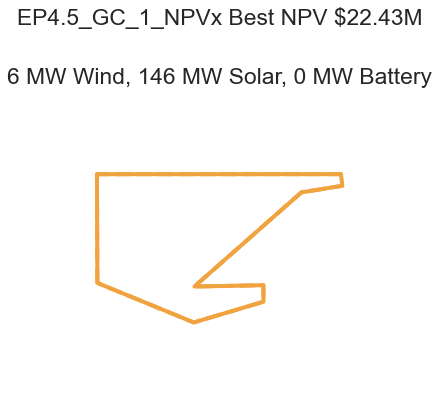

[7.471883872099422, 1.0, 1.0338314905360235, 0.0708678010521322, 1.0, 0.0, 0.3512411966085236, 0.4262158621687766, 1.7731139839826067, 0.329233414950439, 5.001064443809419, 3.0474801348105607, 0.7994974776989321, 0.000476976997019863] 22432527.176802386 22432566.86076626 EP4.5_GC_1_NPV
-37621914.26328994
EP4.5_GC_1_NPV mean 22.43256686076626 stdev nan median 22.43256686076626



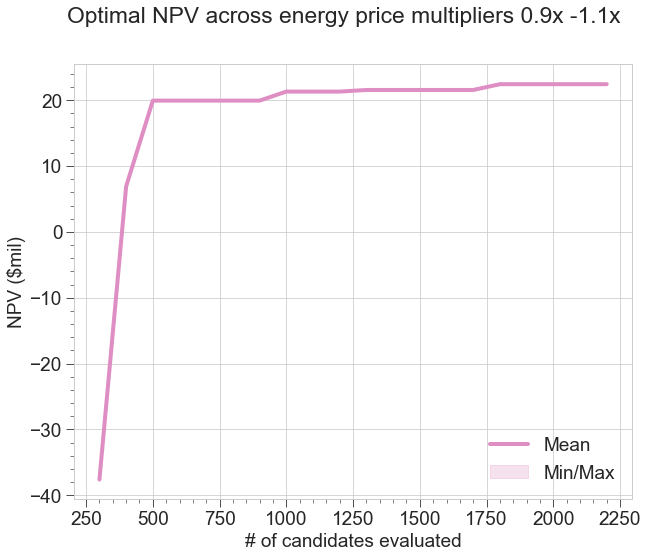

-37621914.26328994


In [88]:
current_run = run_group = 'EP4.5_GC_1_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(flatirons_site, runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 235774.179 kw into existing PV layout parameters of PVGridParameters(x_position=0.7369359707637884, y_position=0.45205959375544646, aspect_power=2.240607255718554, gcr=0.36132709937426405, s_buffer=5.003081324262412, x_buffer=6.757572842951429)


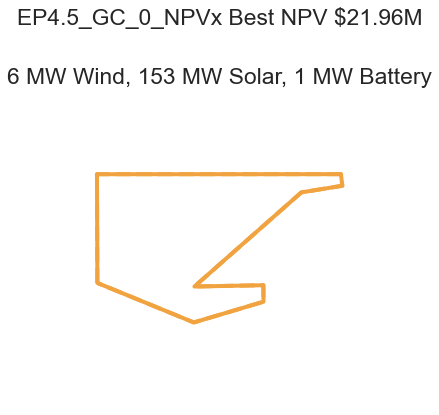

[1.1683146289488662, 0.9677267949422254, 2.0265365617141775, 3.059647319144945, 0.8983619337991764, 0.0, 0.7369359707637884, 0.45205959375544646, 2.240607255718554, 0.36132709937426405, 5.003081324262412, 6.757572842951429, 0.7859149117497397, 0.0022261083941290637] 21958330.478431657 21958408.888789177 EP4.5_GC_0_NPV
-41575805.7390924
EP4.5_GC_0_NPV mean 21.958408888789176 stdev nan median 21.958408888789176



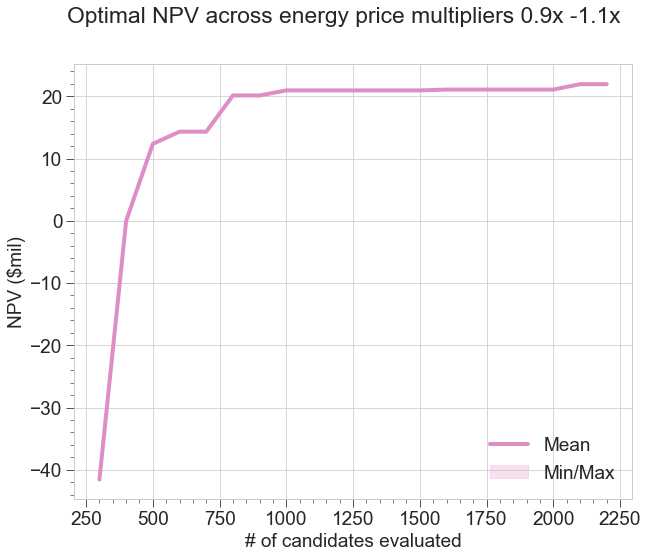

-41575805.7390924


In [89]:
current_run = run_group = 'EP4.5_GC_0_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(flatirons_site, runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

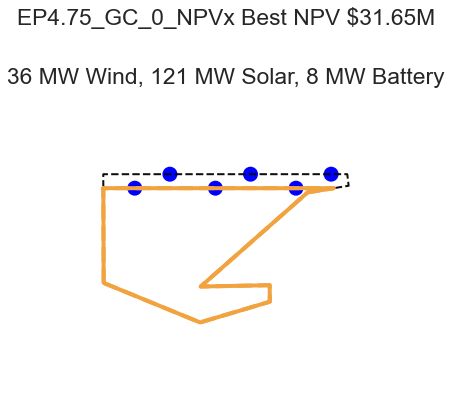

[1.947294194049336, 1.0, 0.5177757160667842, -3.2711833476445102, 0.0, 0.16100450148740592, 0.8975477088354141, 0.22460376661004944, -0.9002472012139167, 0.3206161684176608, 6.499548550976856, 2.527853601415318, 0.40428714040819014, 0.02644439286240078] 31653384.728356875 31653434.031361878 EP4.75_GC_0_NPV
-31927341.976143386
EP4.75_GC_0_NPV mean 32.71264879263058 stdev nan median 32.71264879263058



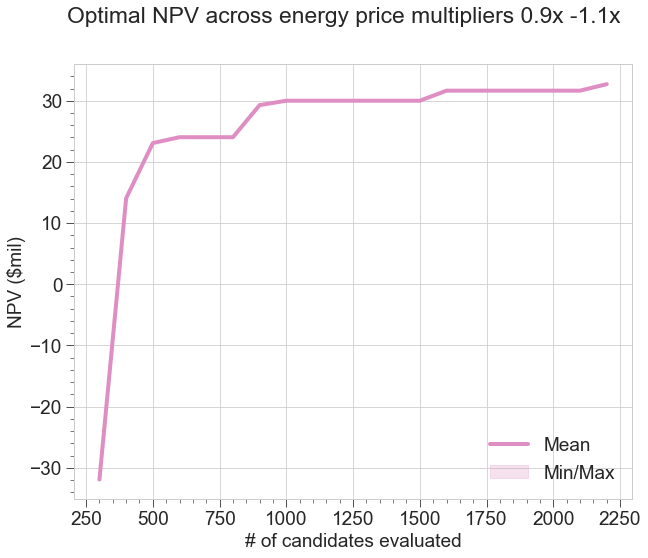

-31927341.976143386


In [87]:
current_run = run_group = 'EP4.75_GC_0_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(flatirons_site, runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

Could not fit 251895.441 kw into existing PV layout parameters of PVGridParameters(x_position=0.5444040617598364, y_position=0.6245781675341692, aspect_power=2.3119516096242223, gcr=0.3693071739510719, s_buffer=0.0, x_buffer=3.0904779751904785)


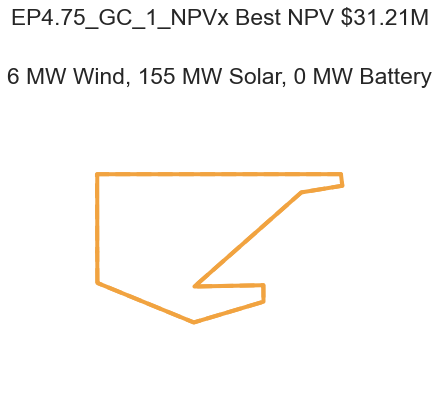

[7.066480807614397, 0.11536848727063803, 0.0, -1.061488838668058, 0.6313570707703162, 0.0, 0.5444040617598364, 0.6245781675341692, 2.3119516096242223, 0.3693071739510719, 0.0, 3.0904779751904785, 0.8396522055850598, 8.82898144677624e-05] 31212281.082439207 31212301.550926417 EP4.75_GC_1_NPV
-20542478.678487595
EP4.75_GC_1_NPV mean 31.212301550926416 stdev nan median 31.212301550926416



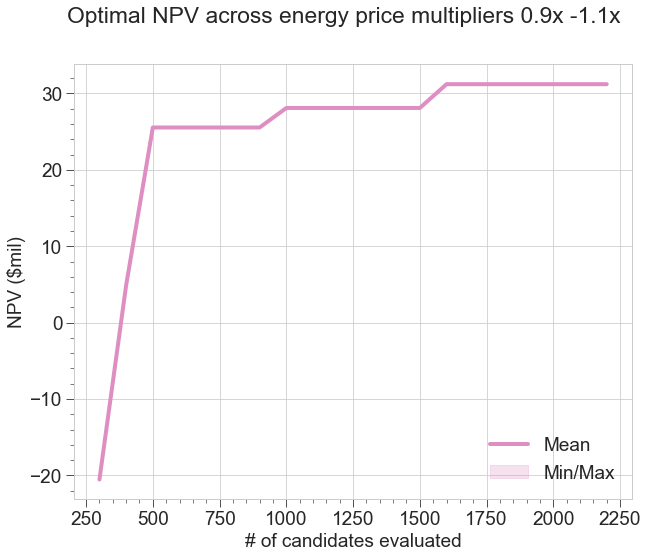

-20542478.678487595


In [86]:
current_run = run_group = 'EP4.75_GC_1_NPV'
runs = data_sets[run_group]
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(flatirons_site, runs, run_group, site_fig_size)

ordering = [current_run]
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["Mean", "Min/Max"], loc='lower right')

plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
print(baseline_value)

-24402859.282458786
default_no_grid_charge_results mean 154.83829219326643 stdev 53.270478226293754 median 152.81220484756125

default_high_wind_no_grid_charge_results mean 183.46389708250732 stdev 53.34723909497129 median 183.4769111844542

high_wind_no_grid_charge_results mean 26.878491846333187 stdev 31.380819874937742 median 19.272171417575716

financial_no_grid_charge_results mean 12.40510101550804 stdev 20.649237664379935 median 0.9731365677457601



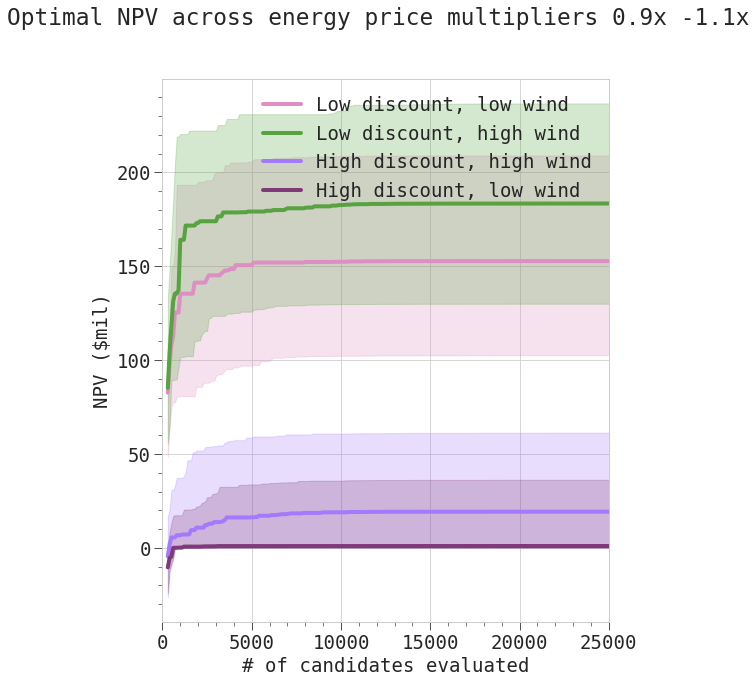

-24402859.282458786


In [237]:
ordering = ("default_no_grid_charge_results", "default_high_wind_no_grid_charge_results", "high_wind_no_grid_charge_results", "financial_no_grid_charge_results")
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering, (8, 10))
plt.legend(["Low discount, low wind", "Low discount, high wind", "High discount, high wind", "High discount, low wind"], loc='upper right')

# ax.set_ylim(3.1, 4.5)
# ax.set_yticks([3.5, 4.0, 4.5])
ax.set_xlim(0, 25000)
# ax.set_xticks([0,10000,20000,30000,40000,50000])
# ax2.set_yticks([219, 220, 221])
plt.suptitle("Optimal NPV across energy price multipliers 0.9x -1.1x")
plt.show()
# plt.savefig(name + 'progress.svg')
print(baseline_value)

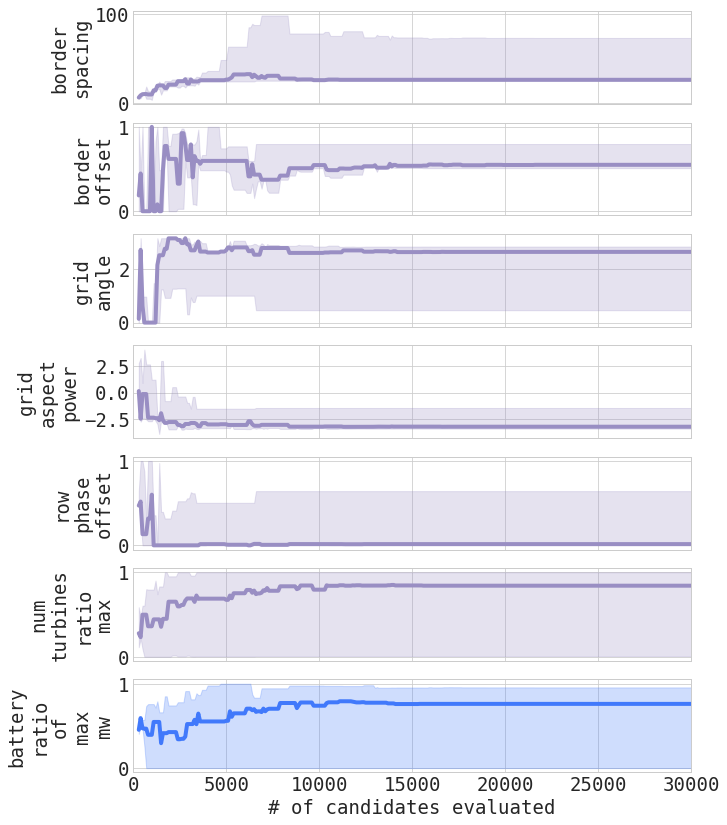

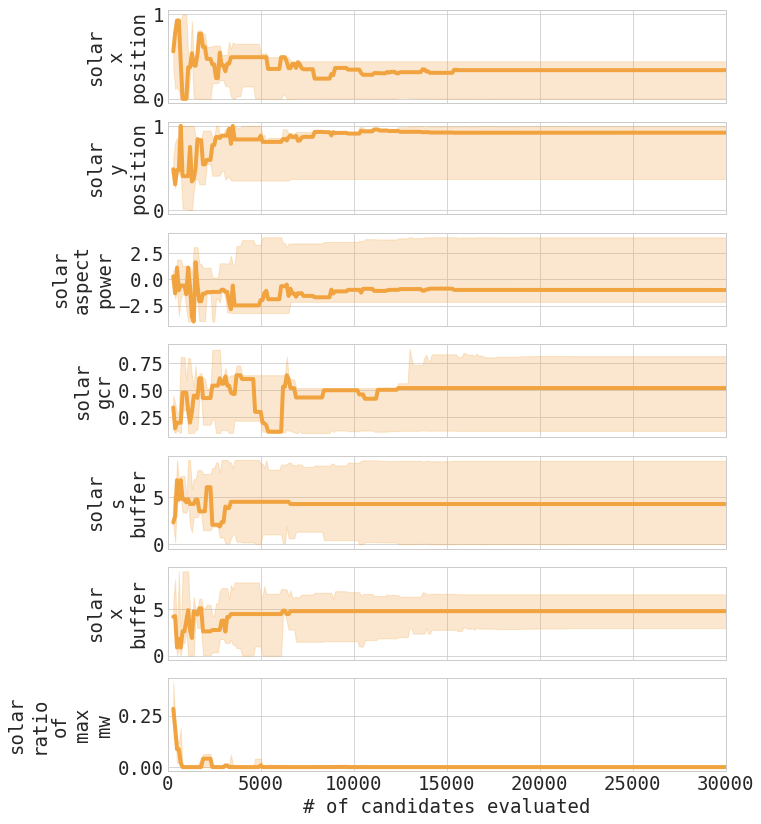

In [150]:
run_group = 'high_wind_no_grid_charge_results'
aggregated_data_sets = make_aggregated_data_set(data_sets)

solar_vars = [var for var in solution_vars if var.startswith('solar')]
wind_vars = [var for var in solution_vars if not var.startswith('solar') and not var.startswith('batt')]
batt_vars = [var for var in solution_vars if var.startswith('batt')]


def plot_solution_vars(solution_vars):
    fig, axs = plt.subplots(len(solution_vars), sharex=True, figsize=[10,2*len(solution_vars)])
    for i, var in enumerate(solution_vars):
        col_name = 'best_solution.' + var
        ax = axs[i]
        ax.set_xlim(0, 30000)
        ax.set(ylabel=var.replace('_','\n'))
        run_data = aggregated_data_sets[run_group]
        x = run_data['num_evaluations'].median(1) + 200
        if var.startswith('batt'):
            color = batt_color
        elif var.startswith('solar'):
            color = solar_color 
        else:
            color = wind_color
        plot_quantiles(ax, x, run_data[col_name], color=color)

    plt.xlabel('# of candidates evaluated')

plot_solution_vars(wind_vars + batt_vars)
# plt.savefig(name + 'solution_trajectories_solar.svg')

plot_solution_vars(solar_vars)
# plt.savefig(name + 'solution_trajectories_wind.svg')